In [8]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import h5py
import sys

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *

label_plot = [
    r"$\\Delta{\\mathcal{A}}$",
    r"$\\Delta{\\alpha}$",
    r"$\\Delta{f_{\\mathrm{knee}}}$",
    r"$\\Delta{f_{1}}$",
    r"$\\Delta{f_{2}}$",
    r"$\\Delta{\\sin \\beta}$",
    r"$\\Delta{\\lambda}$",
    r"$\\Delta{\\sin \\psi}$",
    r"$\\Delta{\\sigma_1^2}$",
    r"$\\Delta{\\sigma_2^2}$",
    r"$\\Delta{\\mathcal{P}_{\\mathrm{tm}}}$",
    r"$\\Delta{\\mathcal{P}_{\\mathrm{oms}}}$",
]


In [9]:
colors_tot = get_colormap_colors(24, "plasma")
colors = colors_tot[:12][::-1]

In [10]:
# NOTE: Here, I am updating pe yaml files with the correct injected fr1 and fknee values and amplitude since they do not match the injected values in the injected yaml files.
# NOTE: This does not influence any of the results in the paper since the correct values were used in the injections and analyses, this is just for consistency in the yaml files.

year = 31555600
for i in range(24):
    # read yaml
    with open(
        f"../data/first_year_twoweeks/pack_{i + 1}/injected_pack{i + 1}.yaml", "r"
    ) as file:
        injected = yaml.safe_load(file)

    a1 = injected["sources"]["galactic_DWD_time"][0]["injected"]
    ak = injected["sources"]["galactic_DWD_time"][1]["injected"]
    b1 = injected["sources"]["galactic_DWD_time"][2]["injected"]
    bk = injected["sources"]["galactic_DWD_time"][3]["injected"]
    amp = injected["sources"]["galactic_DWD_time"][5]["injected"]
    Tobs = injected["sources"]["galactic_DWD_time"][7]["injected"]
    Tobs /= year

    f1 = a1 * np.log10(Tobs) + b1
    fk = ak * np.log10(Tobs) + bk

    yaml_path = f"../data/first_year_twoweeks/pack_{i + 1}/nessai/Gamma/cyclo/pe_pack{i + 1}_cyclo.yaml"
    with open(yaml_path, "r") as file:
        true = yaml.safe_load(file)

    for j in true["sources"]["galactic_DWD_time"]:
        if j["name"] == "fr1":
            j["injected"] = float(round(f1, 3))
        if j["name"] == "fknee":
            j["injected"] = float(round(fk, 3))
        if j["name"] == "amp":
            j["injected"] = amp

    yaml_path_c = f"../data/first_year_twoweeks/pack_{i + 1}/nessai/Gamma/cyclo/pec_pack{i + 1}_cyclo.yaml"
    with open(yaml_path_c, "w") as newfile:
        yaml.dump(true, newfile, default_flow_style=False, allow_unicode=True)
    # newfile.close()

In [11]:
def add_overline(latex_str):
    """Wrap the main LaTeX expression in Delta{}."""
    inner = latex_str.strip("$")  # Remove surrounding dollar signs
    return f"$\\Delta{{{inner}}}$"


def strip_delta(latex_str):
    """Remove Delta from a LaTeX string if present."""
    return re.sub(r"\\Delta{(.*?)}", r"\1", latex_str)


def create_ridgeline_plot(
    data_dict, colors=None, figsize=None, spacing=0.8, alpha=0.7, linewidth=1.0
):
    """
    Create a ridgeline plot from a dictionary of data with proper size management.

    Parameters:
    -----------
    data_dict : dict
        Dictionary with labels as keys and data arrays as values
    colors : list or colormap
        Colors for each distribution
    figsize : tuple
        Figure size (width, height). If None, automatically calculated
    spacing : float
        Vertical spacing between distributions
    alpha : float
        Transparency of filled areas
    linewidth : float
        Width of distribution outlines
    """

    n_distributions = len(data_dict)

    # Automatically calculate figure size if not provided
    if figsize is None:
        # Limit height based on number of distributions
        max_height = 20  # Maximum height in inches
        width = min(12, max(8, n_distributions * 0.5))  # Reasonable width
        height = min(max_height, max(6, n_distributions * spacing + 2))
        figsize = (width, height)
    else:
        # Ensure figsize doesn't exceed reasonable limits
        width, height = figsize
        max_width, max_height = 15, 20
        if width > max_width or height > max_height:
            print(f"Warning: Reducing figsize from {figsize} to reasonable limits")
            width = min(width, max_width)
            height = min(height, max_height)
            figsize = (width, height)

    print(
        f"Creating ridgeline plot with {n_distributions} distributions, figsize: {figsize}"
    )

    fig, ax = plt.subplots(figsize=figsize)

    # Generate colors if not provided
    if colors is None:
        # Create a gradient from purple to orange
        colors = plt.cm.plasma(np.linspace(0.1, 0.9, n_distributions))

    # Calculate global data range for consistent x-axis
    all_data = np.concatenate(list(data_dict.values()))
    data_min, data_max = np.percentile(
        all_data, [1, 99]
    )  # Use percentiles to avoid outliers
    data_range = data_max - data_min
    x_min = data_min - 0.1 * data_range
    x_max = data_max + 0.1 * data_range

    # Plot each distribution
    for i, (label, data) in enumerate(data_dict.items()):
        if len(data) == 0:
            continue

        # Calculate kernel density estimation
        try:
            density = stats.gaussian_kde(data)
            x_range = np.linspace(x_min, x_max, 200)
            y_density = density(x_range)
        except (np.linalg.LinAlgError, ValueError) as e:
            print(
                f"Warning: Could not compute KDE for {label}, using histogram instead"
            )
            # Fallback to histogram
            hist, bin_edges = np.histogram(data, bins=50, density=True)
            x_range = (bin_edges[:-1] + bin_edges[1:]) / 2
            y_density = hist

        # Scale and shift the density curve
        if y_density.max() > 0:
            y_density = y_density / y_density.max() * 0.4  # Scale height
        # Add overlap: reduce spacing and shift slightly up to avoid full overwrite
        overlap_factor = 0.5  # controls how much one row overlaps the next (0 = full overlap, 1 = no overlap)
        adjusted_spacing = spacing * overlap_factor
        y_position = i * adjusted_spacing

        # Plot filled area
        ax.fill_between(
            x_range,
            y_position,
            y_position + y_density,
            alpha=alpha,
            color=colors[i],
            linewidth=0,
        )

        # Plot outline
        ax.plot(x_range, y_position + y_density, color="white", linewidth=linewidth)

        # Add label - adjust position based on data range
        label_x = x_min - 0.05 * data_range
        ax.text(
            label_x, y_position + 0.2, label, verticalalignment="center", ha="right"
        )

    # Customize plot
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.5, n_distributions * spacing)
    ax.set_xlabel("Parameter Value")
    # ticks = np.round(np.linspace(x_min, x_max, 8), 3)
    ticks = np.round(np.linspace(x_min, x_max, 5), 3)  # Fewer ticks
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=45, ha="right")  # Smaller, rotated
    # ax.set_xticks(ticks)
    # ax.set_xticklabels(ticks, fontsize=18)
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis="x")

    plt.tight_layout()
    return fig, ax


def load_posterior_data(n_packs=24, mode="your_mode_here"):
    """
    Load posterior samples from HDF5 files and corresponding true values from YAML

    Parameters:
    -----------
    n_packs : int
        Number of packs to load
    mode : str
        Mode for the analysis

    Returns:
    --------
    all_samples : list
        List of posterior samples for each pack
    parameter_names : list
        Names of the parameters
    true_values : list
        True injected values for each pack
    """

    all_samples = []
    all_true_values = []
    parameter_names = None

    for i in range(n_packs):
        pack_id = i + 1

        # Load posterior samples from HDF5
        hdf5_path = f"../data/first_year_twoweeks/pack_{pack_id}/nessai/Gamma/{mode}/result.hdf5"

        if not Path(hdf5_path).exists():
            print(f"Warning: {hdf5_path} not found, skipping pack_{pack_id}")
            continue

        try:
            with h5py.File(hdf5_path, "r") as f:
                posterior = f["posterior_samples"][:]
                # Get parameter names from dtype (first time only)
                if parameter_names is None:
                    dtype = posterior.dtype
                    parameter_names = list(dtype.names)

        except Exception as e:
            print(f"Error loading {hdf5_path}: {e}")
            continue

        # Load true values from YAML
        yaml_path = f"../data/first_year_twoweeks/pack_{pack_id}/nessai/Gamma/{mode}/pec_pack{pack_id}_{mode}.yaml"

        if Path(yaml_path).exists():
            try:
                with open(yaml_path, "r") as file:
                    sources = yaml.safe_load(file)["sources"]
                    true_values = [
                        item["injected"]
                        for category in sources.values()
                        for item in category
                    ]
            except Exception as e:
                print(f"Error loading {yaml_path}: {e}")
                true_values = [0] * len(parameter_names)
        else:
            print(f"Warning: {yaml_path} not found, using zeros for true values")
            true_values = [0] * len(parameter_names) if parameter_names else []

        # Convert structured array to regular array
        if parameter_names and len(true_values) > 0:
            n_params = min(len(parameter_names), len(true_values))
            samples = np.vstack(
                [posterior[name] for name in parameter_names[:n_params]]
            ).T

            all_samples.append(samples)
            all_true_values.append(true_values[:n_params])

    return (
        all_samples,
        parameter_names[: len(true_values)] if parameter_names else [],
        all_true_values,
    )


def create_parameter_ridgeline_plots(
    all_samples,
    parameter_names,
    pack_labels=None,
    save_plots=False,
    max_packs_per_plot=15,
    all_true_values=None,
    center_on_true_values=False,
    pack_indices=None,
):
    """
    Create separate ridgeline plots for each parameter across all packs
    Split into multiple plots if too many packs to avoid size issues

    Parameters:
    -----------
    all_samples : list
        List of sample arrays, one per pack
    parameter_names : list
        Names of parameters
    pack_labels : list, optional
        Custom labels for packs
    save_plots : bool
        Whether to save plots to files
    max_packs_per_plot : int
        Maximum number of packs per plot to avoid size issues
    all_true_values : list, optional
        True values for each pack
    center_on_true_values : bool
        Whether to center distributions on true values
    pack_indices : list, optional
        Indices of packs to include
    """

    n_packs = len(all_samples)
    n_params = len(parameter_names)

    if pack_labels is None:
        pack_labels = [f"Packet {i + 1}" for i in range(n_packs)]

    # Determine which packs to include
    if pack_indices is not None:
        selected_indices = sorted(set(pack_indices))
    else:
        selected_indices = list(range(len(all_samples)))

    # Split packs into chunks if too many
    pack_chunks = []
    for i in range(0, len(selected_indices), max_packs_per_plot):
        end_idx = min(i + max_packs_per_plot, len(selected_indices))
        chunk = selected_indices[i:end_idx]
        pack_chunks.append(chunk)

    # Create one plot per parameter (split if necessary)
    for param_idx, param_name in enumerate(parameter_names):
        print(f"Creating ridgeline plot(s) for parameter: {param_name}")

        for chunk_idx, chunk in enumerate(pack_chunks):
            # Create gradient colors for this chunk
            colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(chunk)))

            # Extract data for this parameter from this chunk of packs
            param_data = {}
            for pack_idx in chunk:
                if pack_idx < len(all_samples):
                    samples = all_samples[pack_idx]
                    if param_idx < samples.shape[1]:  # Check if parameter exists
                        param_values = samples[:, param_idx]

                        if center_on_true_values and all_true_values is not None:
                            if pack_idx < len(all_true_values) and param_idx < len(
                                all_true_values[pack_idx]
                            ):
                                true_val = all_true_values[pack_idx][param_idx]
                                param_values = param_values - true_val

                        param_data[pack_labels[pack_idx]] = param_values

            if not param_data:  # Skip if no data for this parameter
                continue

            # Create the ridgeline plot
            fig, ax = create_ridgeline_plot(param_data, colors=colors)
            ax.axvline(x=0, color="red", linestyle="--", alpha=0.8)

            try:
                raw_label = label_plot[param_idx]
            except IndexError:
                raw_label = param_name

            if center_on_true_values:
                ax.set_xlabel(f"{raw_label}")
            else:
                raw_label = strip_delta(raw_label)
                ax.set_xlabel(raw_label)

            if save_plots:
                filename_base = f"ridgeline_{param_name.replace('/', '_')}"
                if len(pack_chunks) > 1:
                    filename_base += f"_part{chunk_idx + 1}"
                save_high_quality_plot(fig, filename_base, dpi=200)  # Reduced DPI


def create_combined_ridgeline_plot(
    all_samples,
    parameter_names,
    figsize=None,
    overlap_factor=0.5,
    spacing=0.5,
    alpha=0.7,
    linewidth=1.0,
    center_on_true_values=False,
    all_true_values=None,
    selected_params=None,
    pack_indices=None,
    max_packs_per_plot=12,
):
    """
    Create a grid of ridgeline plots for a selected subset of parameters.

    Parameters:
    -----------
    all_samples : list of np.ndarray
        Posterior samples, one per pack
    parameter_names : list of str
        Names of the parameters
    figsize : tuple
        Optional figure size
    spacing : float
        Vertical spacing
    alpha : float
        Transparency
    linewidth : float
        Outline width
    center_on_true_values : bool
        Center samples on true injected values
    all_true_values : list of lists
        True values for each pack
    selected_params : list of str
        Subset of parameters to plot (can be names or LaTeX labels from label_plot)
    pack_indices : list of int
        Indices of packs to include
    max_packs_per_plot : int
        Maximum number of packs per plot

    Returns:
    --------
    fig, axs : matplotlib Figure and Axes array
    """

    # Determine which packs to include
    if pack_indices is not None:
        selected_pack = sorted(set(pack_indices))
    else:
        selected_pack = list(range(len(all_samples)))

    # Determine selected parameter indices
    if selected_params is not None:
        selected_indices = []
        for p in selected_params:
            if p in parameter_names:
                selected_indices.append(parameter_names.index(p))
            elif p in label_plot:
                selected_indices.append(label_plot.index(p))
            else:
                print(
                    f"Warning: Parameter '{p}' not found in parameter_names or label_plot, skipping."
                )

        if not selected_indices:
            print("No valid parameters selected. Skipping plot.")
            return None, None

        selected_parameter_names = [parameter_names[i] for i in selected_indices]
    else:
        selected_indices = list(range(len(parameter_names)))
        selected_parameter_names = parameter_names

    n_packs = len(selected_pack)
    n_params = len(selected_indices)

    pack_labels = [f"Packet {i + 1}" for i in selected_pack]

    # Prepare data
    data_grid = {}
    for pack_idx, samples in enumerate(all_samples):
        if pack_idx not in selected_pack:
            continue

        pack_label = f"Packet {pack_idx + 1}"
        for param_idx in selected_indices:
            if param_idx < samples.shape[1]:
                param_name = parameter_names[param_idx]
                if param_name not in data_grid:
                    data_grid[param_name] = {}
                values = samples[:, param_idx]
                if center_on_true_values and all_true_values is not None:
                    if pack_idx < len(all_true_values) and param_idx < len(
                        all_true_values[pack_idx]
                    ):
                        values = values - all_true_values[pack_idx][param_idx]
                data_grid[param_name][pack_label] = values

    # Figure size
    if figsize is None:
        width = max(4 * n_params, 100)
        height = max(spacing * n_packs * 2, 8)
        figsize = (width, height)

    fig, axs = plt.subplots(1, n_params, figsize=figsize, sharey=True)
    if n_params == 1:
        axs = [axs]

    for c_idx, param_name in enumerate(selected_parameter_names):
        packs_data = data_grid[param_name]

        # Compute x-limits for this parameter
        all_param_values = np.concatenate(list(packs_data.values()))
        data_min, data_max = np.percentile(all_param_values, [1, 99])
        data_range = data_max - data_min
        x_min = data_min - 0.1 * data_range
        x_max = data_max + 0.1 * data_range

        ax = axs[c_idx]
        # colors = plt.cm.plasma(np.linspace(0.1, 0.9, n_packs))
        # colors = colors[::-1]

        # Global y-limits based on overlap
        adjusted_spacing = spacing * overlap_factor

        for r_idx, pack_label in enumerate(reversed(pack_labels)):
            data = packs_data.get(pack_label, None)
            if data is None or len(data) == 0:
                continue

            try:
                density = stats.gaussian_kde(data)
                x_range = np.linspace(x_min, x_max, 200)
                y_density = density(x_range)
            except (np.linalg.LinAlgError, ValueError):
                hist, bin_edges = np.histogram(data, bins=50, density=True)
                x_range = (bin_edges[:-1] + bin_edges[1:]) / 2
                y_density = hist

            y_density = y_density / y_density.max() * 0.4

            y_pos = r_idx * adjusted_spacing

            ax.fill_between(
                x_range, y_pos, y_pos + y_density, color=colors[r_idx], alpha=alpha
            )
            ax.plot(
                x_range, y_pos + y_density, color="k", alpha=0.3, linewidth=linewidth
            )

            # Add label on the left
            if c_idx == 0:
                ax.text(
                    x_min - 0.05 * data_range,
                    y_pos + 0.1,
                    pack_label,
                    ha="right",
                    va="center",
                )  # , fontsize=20)

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(0, n_packs * adjusted_spacing + 0.25)
        ax.set_yticks([])

        # Plot true value line
        if center_on_true_values:
            ax.axvline(x=0, color="k", linestyle="--", alpha=0.8)
        elif all_true_values is not None and len(all_true_values) > 0:
            true_val = all_true_values[0][selected_indices[c_idx]]
            ax.axvline(x=true_val, color="k", linestyle="--", alpha=0.8)

        # Add x-label
        try:
            label = label_plot[parameter_names.index(param_name)]
        except (IndexError, ValueError):
            label = param_name

        if center_on_true_values:
            ax.set_xlabel(label)  # , fontsize=20)
        else:
            ax.set_xlabel(strip_delta(label))  # , fontsize=20)

        from matplotlib.ticker import MaxNLocator

        ax.xaxis.set_major_locator(MaxNLocator(nbins=3, prune="both"))
        ax.tick_params(axis="x", labelsize=12, rotation=30)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.xaxis.set_tick_params(labelsize=14)

    plt.tight_layout()
    return fig, axs


def save_high_quality_plot(fig, filename, dpi=200):
    """Save plot in high quality for presentations/papers with reasonable DPI"""
    # Use lower DPI to avoid size issues
    fig.savefig(
        f"{filename}.png",
        dpi=dpi,
        bbox_inches="tight",
        facecolor="white",
        edgecolor="none",
    )
    fig.savefig(
        f"{filename}.pdf", bbox_inches="tight", facecolor="white", edgecolor="none"
    )
    print(f"High-quality plots saved as {filename}.png and {filename}.pdf")

In [12]:
def run_complete_analysis(
    mode="your_mode_here", n_packs=24, max_packs_per_plot=15, pack_indices=None
):
    """
    Run complete analysis including data loading and all visualizations
    """
    print(f"Starting analysis for mode: {mode}")
    print("Loading data...")

    # Load data
    all_samples, parameter_names, all_true_values = load_posterior_data(
        n_packs=n_packs, mode=mode
    )

    if not all_samples:
        print("No data loaded. Please check your file paths and mode.")
        return None, None, None

    print(
        f"Successfully loaded {len(all_samples)} packs with {len(parameter_names)} parameters"
    )

    if len(all_samples) > max_packs_per_plot:
        print(
            f"Note: Splitting plots due to {len(all_samples)} packs (max {max_packs_per_plot} per plot)"
        )

    print("\nCreating combined ridgeline plot...")
    fig, ax = create_combined_ridgeline_plot(
        all_samples,
        parameter_names,
        overlap_factor=0.8,
        spacing=0.4,
        figsize=(16, 8),
        all_true_values=all_true_values,
        center_on_true_values=True,
        pack_indices=pack_indices,
        selected_params=[
            r"$\\Delta{\\alpha}$",
            r"$\\Delta{\\mathcal{A}}$",
            r"$\\Delta{f_{\\mathrm{knee}}}$",
            r"$\\Delta{f_{1}}$",
            r"$\\Delta{f_{2}}$",
            r"$\\Delta{\\sin \\beta}$",
            r"$\\Delta{\\lambda}$",
            r"$\\Delta{\\sin \\psi}$",
            r"$\\Delta{\\sigma_1^2}$",
            r"$\\Delta{\\sigma_2^2}$",
            # r'$\Delta{\mathcal{P}_{\mathrm{tm}}}$', r'$\Delta{\mathcal{P}_{\mathrm{oms}}}$'
        ],
    )

    if fig is not None:
        fig.savefig("../plots/tot_ridgeline_first.pdf", dpi=300, bbox_inches="tight")
        print("Combined ridgeline plot created and saved.")

    return all_samples, parameter_names, all_true_values, fig

Starting analysis for mode: cyclo
Loading data...
Successfully loaded 24 packs with 12 parameters

Creating combined ridgeline plot...
Combined ridgeline plot created and saved.


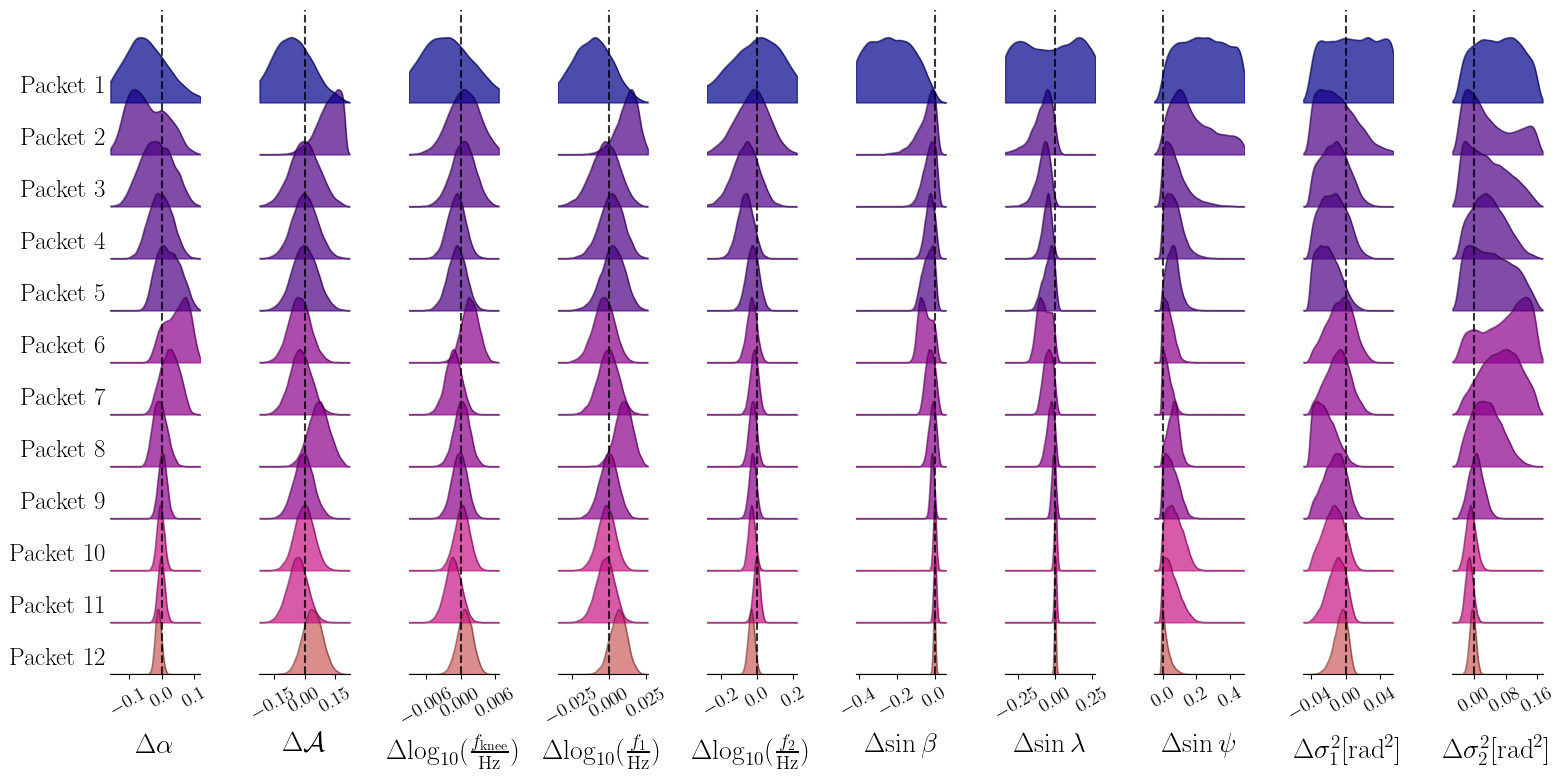

In [13]:
mode = "cyclo"  # UPDATE THIS WITH YOUR ACTUAL MODE!
colors = colors_tot[:12][::-1]
# Run complete analysis with size management
all_samples, parameter_names, all_true_values, fig = run_complete_analysis(
    mode=mode,
    n_packs=24,
    max_packs_per_plot=24,
    pack_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
)

kwargs = dict(fontsize=20)
fig.axes[0].set_xlabel(r"$\Delta\alpha$", **kwargs)
fig.axes[1].set_xlabel(r"$\Delta{\mathcal A}$", **kwargs)
fig.axes[2].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm knee}}{{\rm Hz}}})$", **kwargs)
fig.axes[3].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm 1}}{{\rm Hz}}})$", **kwargs)
fig.axes[4].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm 2}}{{\rm Hz}}})$", **kwargs)
fig.axes[5].set_xlabel(r"$\Delta{\sin \beta}$", **kwargs)
fig.axes[6].set_xlabel(r"$\Delta{\sin \lambda}$", **kwargs)
fig.axes[7].set_xlabel(r"$\Delta{\sin \psi}$", **kwargs)
fig.axes[8].set_xlabel(r"$\Delta{\sigma_1^2} [{\rm rad}^2]$ ", **kwargs)
fig.axes[9].set_xlabel(r"$\Delta{\sigma_2^2} [{\rm rad}^2]$ ", **kwargs)
# Align all x labels vertically
fig.align_xlabels(axs=[ax for ax in fig.axes])
fig.savefig("../plots/Figure3top.pdf", dpi=300, bbox_inches="tight")


Starting analysis for mode: cyclo
Loading data...
Successfully loaded 24 packs with 12 parameters

Creating combined ridgeline plot...
Combined ridgeline plot created and saved.


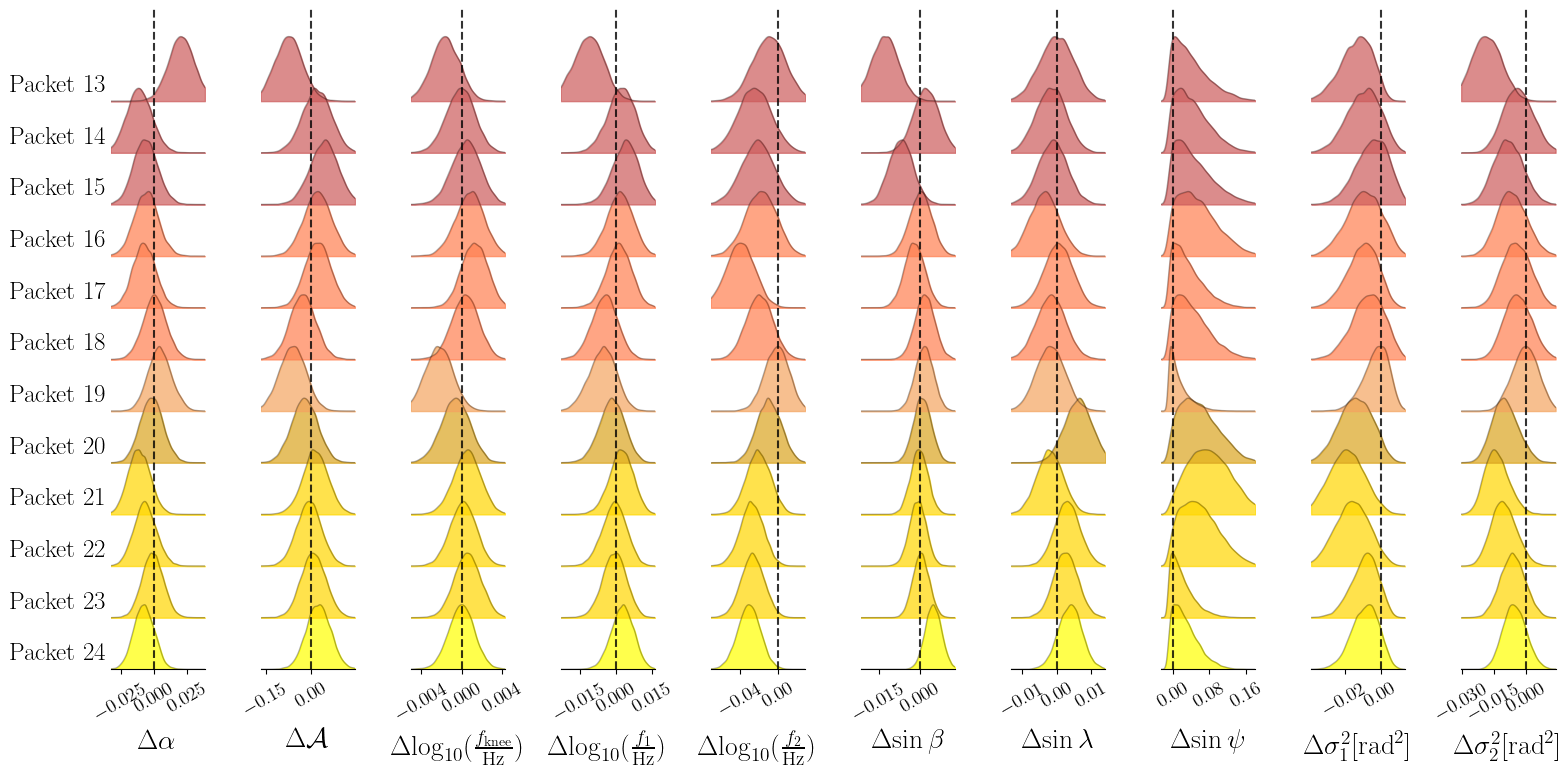

In [14]:
mode = "cyclo"  # UPDATE THIS WITH YOUR ACTUAL MODE!
# Run complete analysis with size management
colors = colors_tot[12:][::-1]
all_samples, parameter_names, all_true_values, fig = run_complete_analysis(
    mode=mode,
    n_packs=24,
    max_packs_per_plot=24,
    pack_indices=[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
)

kwargs = dict(fontsize=20)
fig.axes[0].set_xlabel(r"$\Delta\alpha$", **kwargs)
fig.axes[1].set_xlabel(r"$\Delta{\mathcal A}$", **kwargs)
fig.axes[2].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm knee}}{{\rm Hz}}})$", **kwargs)
fig.axes[3].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm 1}}{{\rm Hz}}})$", **kwargs)
fig.axes[4].set_xlabel(r"$\Delta{\log_{10} (\frac{f_{\rm 2}}{{\rm Hz}}})$", **kwargs)
fig.axes[5].set_xlabel(r"$\Delta{\sin \beta}$", **kwargs)
fig.axes[6].set_xlabel(r"$\Delta{\sin \lambda}$", **kwargs)
fig.axes[7].set_xlabel(r"$\Delta{\sin \psi}$", **kwargs)
fig.axes[8].set_xlabel(r"$\Delta{\sigma_1^2} [{\rm rad}^2]$ ", **kwargs)
fig.axes[9].set_xlabel(r"$\Delta{\sigma_2^2} [{\rm rad}^2]$ ", **kwargs)
# Align all x labels vertically
fig.align_xlabels(axs=[ax for ax in fig.axes])
fig.savefig("../plots/Figure3bottom.pdf", dpi=300, bbox_inches="tight")
